In [15]:
import torch
import triton
import triton.language as tl

DEVICE = torch.device("cuda:0")

In [16]:
@triton.jit
def sub_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x - y
    tl.store(output_ptr + offsets, output, mask=mask)

In [17]:
def sub(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    grid = lambda x: (triton.cdiv(n_elements, x["BLOCK_SIZE"]), )
    sub_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output

In [18]:
# Example of 1D vector subtraction using Triton. 
torch.manual_seed(0)
size = 1024*6
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
torch_output = x - y
triton_output = sub(x, y)
print(torch_output)
print(triton_output)
print(f"The maximum difference between torch and triton is "
      f"{torch.max(torch.abs(torch_output - triton_output))}")

tensor([-0.5732, -0.2743, -0.4441,  ...,  0.0503,  0.7123, -0.1336],
       device='cuda:0')
tensor([-0.5732, -0.2743, -0.4441,  ...,  0.0503,  0.7123, -0.1336],
       device='cuda:0')
The maximum difference between torch and triton is 0.0


**Note**
- The proper explanation of above code can be found in [vector_add.ipynb](./vector_add.ipynb)

In [19]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x - y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: sub(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

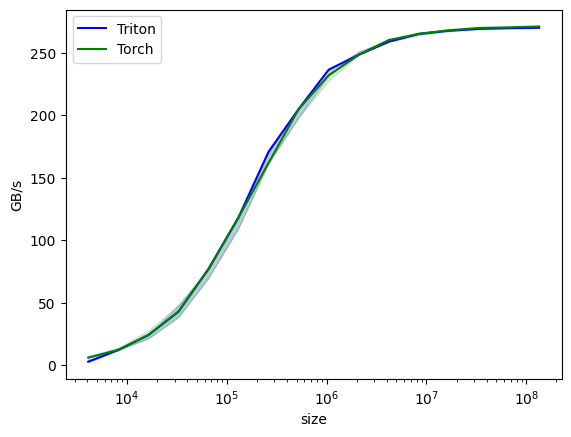

vector-add-performance:
           size      Triton       Torch
0        4096.0    2.666667    6.000000
1        8192.0   12.000000   12.000000
2       16384.0   24.000000   24.000000
3       32768.0   42.666665   42.666665
4       65536.0   76.800002   76.800002
5      131072.0  118.153847  118.153847
6      262144.0  170.666661  161.684218
7      524288.0  204.800005  204.800005
8     1048576.0  236.307695  231.849058
9     2097152.0  248.242431  248.242431
10    4194304.0  258.694729  260.063494
11    8388608.0  264.970349  264.970349
12   16777216.0  267.493874  267.858310
13   33554432.0  268.957600  269.695465
14   67108864.0  269.556793  270.158704
15  134217728.0  269.834281  270.903205


In [20]:
benchmark.run(print_data=True, show_plots=True)